In [167]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd

In [168]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [169]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [170]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [171]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [172]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [173]:
text_embs.shape

torch.Size([1000, 1024])

In [174]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [175]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [176]:
many_labels = []
many_embs = []
med_labels = []
med_embs = []
few_labels = []
few_embs = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

  0%|          | 0/50000 [00:00<?, ?it/s]

### Alternate Train(?) Scheme: Leveraging CLIP Zero-shot top-K 

In [177]:
# Pairwise cosine similarity between image and text 
import sklearn 
pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), text_embs.cpu())
pairwise_cs.shape

(50000, 1000)

In [178]:
def top_k_acc(pairwise_cs, k, labels):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :k]
    acc = 0
    for i in range(indices.shape[0]):
        if labels[i].item() in indices[i]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc

In [223]:
hnym_embs = {}

def populate_hnym_embs():
    for i in tqdm(range(1000)):
        pred = CLASSES[i]
        pred = pred.lower().replace(" ", "_").replace("-", "_")        
        syns = wn.synsets(pred, wn.NOUN)

        with torch.no_grad():
            for syn in syns: 
                hnms = []
#                 hnms.extend(syn.hypernyms())
#                 hnms.extend(syn.hyponyms())
                hnms.extend(syn.lemmas())
#                 hnms.extend(syn.definition())
                if len(hnms) > 0:
                    texts = clip.tokenize([hnm.name() for hnm in hnms])
#                     texts = clip.tokenize(hnms[0])
                    texts = texts.cuda()
                    zeroshot_weights = clip_model.encode_text(texts).float()
                    zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
                        dim=-1, keepdim=True
                    )
                    
                    hnym_embs[syn.name()] = torch.mean(zeroshot_weights, axis=0).unsqueeze(0)
populate_hnym_embs()

def get_hnym_similarity(i, pred):
    img = image_embeddings[i].unsqueeze(0)
    
    pred = pred.lower().replace(" ", "_").replace("-", "_")
    syns = wn.synsets(pred, wn.NOUN)

    all_sims = []
    with torch.no_grad():
        for syn in syns:
            if syn.name() in hnym_embs:
                pairwise = sklearn.metrics.pairwise.cosine_similarity(img.cpu(), hnym_embs[syn.name()].cpu())
                all_sims.append(pairwise)
            else:
                hnms = []
#                 hnms.extend(syn.hypernyms())
#                 hnms.extend(syn.hyponyms())
                hnms.extend(syn.lemmas())
#                 hnms.extend(syn.definition())
                if len(hnms) > 0:
                    texts = clip.tokenize([hnm.name() for hnm in hnms]) 
#                     texts = clip.tokenize(hnms[0])
                    texts = texts.cuda()
                    zeroshot_weights = clip_model.encode_text(texts).float()
                    zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
                        dim=-1, keepdim=True
                    )
                    zeroshot_weights = torch.mean(zeroshot_weights, axis=0).unsqueeze(0)
                    hnym_embs[syn.name()] = zeroshot_weights
                    pairwise = sklearn.metrics.pairwise.cosine_similarity(img.cpu(), zeroshot_weights.cpu())
                    all_sims.append(pairwise)
                    
    if len(all_sims) == 0:
        return -1
    return np.max(all_sims)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [224]:
import warnings
warnings.filterwarnings("ignore")
cache = {i:{} for i in range(indices.shape[0])}
ds = []
def top_1_acc_with_distance(pairwise_cs, k, labels, dist = 3):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :k]
    acc = 0
    for i in tqdm(range(indices.shape[0])):
        d= get_shortest_distance_wordnet(CLASSES[indices[i][0]], CLASSES[indices[i][1]])
        ds.append(d)
        if d < dist:
            m = 0
        else:
            wordnet_sims = []
            for j in indices[i]:
                if j in cache[i]:
                    sim = cache[i][j]
                else:
                    sim = get_hnym_similarity(i, CLASSES[j])
                    cache[i][j] = sim
                wordnet_sims.append(sim)
            if -1 in wordnet_sims:
                m = 0
            else:
                m = np.argmax(wordnet_sims)
#         print(m)
#         print(indices)
        if labels[i].item() == indices[i][m]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc

# for i in range(1, 20):
#     acc = top_1_acc_with_distance(pairwise_cs, i, labels)
#     print(f"Top {i} zero-shot accuracy: {acc}")

for d in reversed(range(1, 22)):
    acc = top_1_acc_with_distance(pairwise_cs, 2, labels, dist = d)
    print(f"Accuracy: {acc}, D: {d}")

  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.58142, D: 21


  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.58142, D: 20


  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.5814, D: 19


  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.58136, D: 18


  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.58134, D: 17


  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.58132, D: 16


  0%|          | 0/50000 [00:00<?, ?it/s]

Accuracy: 0.58128, D: 15


  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

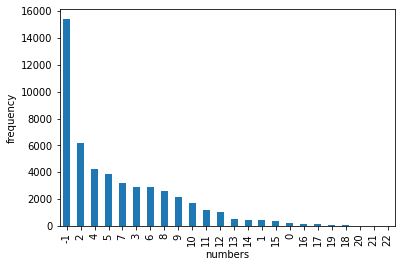

In [196]:
plt.rcParams["figure.figsize"] = (30,30)
import seaborn as sns

df = pd.DataFrame({'distances': ds})
df['distances'].value_counts().plot(kind='bar', xlabel='numbers', ylabel='frequency')

plt.show()

In [200]:
for i in range(1, 20):
    acc = top_k_acc(pairwise_cs, i, labels)
    print(f"Top {i} zero-shot accuracy: {acc}")

Top 1 zero-shot accuracy: 0.58142
Top 2 zero-shot accuracy: 0.72362
Top 3 zero-shot accuracy: 0.78862
Top 4 zero-shot accuracy: 0.8256
Top 5 zero-shot accuracy: 0.85264
Top 6 zero-shot accuracy: 0.8712
Top 7 zero-shot accuracy: 0.88546
Top 8 zero-shot accuracy: 0.89656
Top 9 zero-shot accuracy: 0.90484
Top 10 zero-shot accuracy: 0.91278
Top 11 zero-shot accuracy: 0.91898
Top 12 zero-shot accuracy: 0.92476
Top 13 zero-shot accuracy: 0.92934
Top 14 zero-shot accuracy: 0.93372
Top 15 zero-shot accuracy: 0.93728
Top 16 zero-shot accuracy: 0.94056
Top 17 zero-shot accuracy: 0.94312
Top 18 zero-shot accuracy: 0.94602
Top 19 zero-shot accuracy: 0.94854


In [17]:
# Pairwise cosine similarity between image and text 
import sklearn 
pairwise_cs_train = sklearn.metrics.pairwise.cosine_similarity(image_embeddings_train.cpu(), text_embs.cpu())
pairwise_cs_train.shape

(115846, 1000)

In [18]:
for i in range(1, 20):
    acc = top_k_acc(pairwise_cs_train, i, labels_train)
    print(f"Top {i} zero-shot accuracy: {acc}")

Top 1 zero-shot accuracy: 0.5597258429294063
Top 2 zero-shot accuracy: 0.7079225868825855
Top 3 zero-shot accuracy: 0.7743556100340107
Top 4 zero-shot accuracy: 0.8123715967750289
Top 5 zero-shot accuracy: 0.8385788028934965
Top 6 zero-shot accuracy: 0.8574745783194931
Top 7 zero-shot accuracy: 0.8719506931616111
Top 8 zero-shot accuracy: 0.8834141878010462
Top 9 zero-shot accuracy: 0.8925470020544516
Top 10 zero-shot accuracy: 0.9000915007855256
Top 11 zero-shot accuracy: 0.9068073131571224
Top 12 zero-shot accuracy: 0.9125476926264179
Top 13 zero-shot accuracy: 0.9174680178858139
Top 14 zero-shot accuracy: 0.9217668283756021
Top 15 zero-shot accuracy: 0.9257548814805863
Top 16 zero-shot accuracy: 0.9292509020596309
Top 17 zero-shot accuracy: 0.9326778654420523
Top 18 zero-shot accuracy: 0.9357681749909362
Top 19 zero-shot accuracy: 0.9385822557533277


In [28]:
from nltk.corpus import wordnet as wn
def get_shortest_distance_wordnet(a, b):
    a = a.lower().replace(" ", "_")
    b = b.lower().replace(" ", "_")
    
    a_syns = wn.synsets(a, wn.NOUN)
    b_syns = wn.synsets(b, wn.NOUN)
    
    dist = []
    
    for a in a_syns:
        for b in b_syns:
            dist.append(a.shortest_path_distance(b))
    if len(dist) == 0:
        return -1
    return min(dist)
    
# print(CLASSES[0], CLASSES[1], CLASSES[100])
# # get_shortest_distance_wordnet

# print(get_shortest_distance_wordnet(CLASSES[0], CLASSES[1]))
# print(get_shortest_distance_wordnet(CLASSES[0], CLASSES[100]))

tench goldfish black swan
2
12


  0%|          | 0/1000 [00:00<?, ?it/s]

In [140]:
hnym_embs

{'tench.n.01': tensor([[-0.0222,  0.0382, -0.0311,  ..., -0.0332,  0.0208,  0.0176]],
        device='cuda:0'),
 'goldfish.n.01': tensor([[-0.0222,  0.0382, -0.0311,  ..., -0.0332,  0.0208,  0.0176]],
        device='cuda:0'),
 'great_white_shark.n.01': tensor([[-0.0339, -0.0063, -0.0027,  ..., -0.0120,  0.0159, -0.0201]],
        device='cuda:0'),
 'tiger_shark.n.01': tensor([[ 0.0045,  0.0012,  0.0026,  ..., -0.0129,  0.0200, -0.0073]],
        device='cuda:0'),
 'hammerhead.n.03': tensor([[-0.0211,  0.0040, -0.0077,  ..., -0.0196,  0.0105,  0.0031]],
        device='cuda:0'),
 'electric_ray.n.01': tensor([[ 0.0016,  0.0145,  0.0001,  ...,  0.0018, -0.0146,  0.0004]],
        device='cuda:0'),
 'stingray.n.01': tensor([[ 0.0016,  0.0145,  0.0001,  ...,  0.0018, -0.0146,  0.0004]],
        device='cuda:0'),
 'cock.n.04': tensor([[-0.0159,  0.0009,  0.0156,  ..., -0.0085, -0.0263,  0.0031]],
        device='cuda:0'),
 'hen.n.01': tensor([[-0.0159,  0.0009,  0.0156,  ..., -0.0085, -0.02

In [141]:
# def get_hnym_similarity(i, pred):
#     img = image_embeddings[i].unsqueeze(0)
    
#     pred = pred.lower().replace(" ", "_").replace("-", "_")
#     syns = wn.synsets(pred, wn.NOUN)

#     all_sims = [0]
#     with torch.no_grad():
#         for syn in syns:
#             hnms = syn.hypernyms() 
#             hnms.extend(syn.hyponyms())
#             if len(hnms) > 0:
#                 texts = clip.tokenize([hnm.name() for hnm in hnms]) 
#                 texts = texts.cuda()
#                 zeroshot_weights = clip_model.encode_text(texts).float()
#                 zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
#                     dim=-1, keepdim=True
#                 )
#                 pairwise = sklearn.metrics.pairwise.cosine_similarity(img.cpu(), zeroshot_weights.cpu())
#                 pairwise = np.mean(pairwise, axis=-1)
#                 all_sims.append(pairwise)
#     return max(all_sims)



In [78]:
import pandas 

indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :3]
vals = np.sort(-torch.tensor(pairwise_cs).softmax(dim=-1).numpy(), axis=-1)[:, :3]
outs = []
for i in range(500):
    if labels[i].item() == indices[i][1]:
#         if labels[i].item() in indices[i]:

        l = CLASSES[labels[i].item()]
        outs.append([CLASSES[labels[i].item()], CLASSES[indices[i][0]], CLASSES[indices[i][1]], CLASSES[indices[i][2]]])
        outs.append([CLASSES[labels[i].item()], vals[i][0], vals[i][1], vals[i][2]])
        outs.append([l, get_hyponym_similarity(i, CLASSES[indices[i][0]]), get_hyponym_similarity(i, CLASSES[indices[i][1]]), get_hyponym_similarity(i, CLASSES[indices[i][2]])])
        

df = pd.DataFrame(outs, columns = ['True', 'Pred 1', 'Pred 2', 'Pred 3'])
df


,True,Pred 1,Pred 2,Pred 3
0,amphibious vehicle,tank,amphibious vehicle,half-track
1,amphibious vehicle,-0.001147,-0.001103,-0.001094
2,amphibious vehicle,[0.22589636],[0.17733905],[0.22811605]
3,rooster,hen,rooster,sulphur-crested cockatoo
4,rooster,-0.001146,-0.001142,-0.001092
5,rooster,[0.22092856],[0.21490395],0
6,sturgeon,silver salmon,sturgeon,fishing casting reel
7,sturgeon,-0.001112,-0.001101,-0.001097
8,sturgeon,[0.14640242],[0.10752983],0
9,hen,rooster,hen,quail
